In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from datetime import date

In [6]:
import plotly.offline as py
import plotly.graph_objs as go

In [7]:
py.init_notebook_mode(connected=True)
%matplotlib inline

In [8]:
data = pd.read_hdf('data_5m/binance.hdf', 'BTC/USDT').astype(np.float32)

In [9]:
data_c = data.set_index('timestamp')

In [10]:
data_c = data_c[~data_c.index.duplicated(keep='first')]

In [11]:
data_c.index = pd.DatetimeIndex(pd.to_datetime(data_c.index, unit='ms'), freq='infer')

In [12]:
data_c = data_c.resample('5min').mean()

In [13]:
data_c = data_c.interpolate()

In [14]:
data_c = data_c.reset_index()

In [15]:
data_c['date'] = data_c['timestamp'].dt.date

In [26]:
group = data_c.groupby('timestamp') #group = data_c.groupby('date')

In [27]:
Daily_Volume =  group['volume'].mean() #data_c['volume']

In [28]:
Daily_Volume.head()

timestamp
2017-08-17 04:00:00    2.189061
2017-08-17 04:05:00    0.000000
2017-08-17 04:10:00    0.484666
2017-08-17 04:15:00    1.406618
2017-08-17 04:20:00    2.328570
Name: volume, dtype: float32

In [29]:
Daily_Volume.tail()

timestamp
2019-03-19 02:55:00    55.929916
2019-03-19 03:00:00    55.465103
2019-03-19 03:05:00    59.437634
2019-03-19 03:10:00    63.410164
2019-03-19 03:15:00     6.150093
Name: volume, dtype: float32

In [30]:
df1 = Daily_Volume.to_frame() 

In [31]:
working_data = df1
working_data = working_data.reset_index()
working_data.head()

,timestamp,volume
0,2017-08-17 04:00:00,2.189061
1,2017-08-17 04:05:00,0.000000
2,2017-08-17 04:10:00,0.484666
3,2017-08-17 04:15:00,1.406618
4,2017-08-17 04:20:00,2.328570


In [32]:
from sklearn.model_selection import train_test_split

In [33]:
scaler = MinMaxScaler()

In [34]:
working_data.shape

(166744, 2)

In [35]:
reshaped_working_data = np.reshape(working_data.volume.values, (len(working_data), 1))

In [36]:
scaled_reshaped_working_data = scaler.fit_transform(reshaped_working_data)

In [37]:
df_train, df_test = train_test_split(scaled_reshaped_working_data, test_size=0.20, shuffle=False)

In [38]:
df_test[:10]

array([[0.02320638],
       [0.02926968],
       [0.02165065],
       [0.02459835],
       [0.02754605],
       [0.02854387],
       [0.02704358],
       [0.09980641],
       [0.17256926],
       [0.0954784 ]], dtype=float32)

In [39]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [40]:
df_test.shape

(33349, 1)

In [41]:
look_back = 1
X_train, Y_train = create_lookback(df_train, look_back)
X_test, Y_test = create_lookback(df_test, look_back)

In [42]:
X_test.shape

(33348, 1)

In [43]:
Y_test.shape

(33348,)

In [44]:
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [45]:
X_test.shape

(33348, 1, 1)

In [46]:
model = Sequential()
model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False, 
                validation_data=(X_test, Y_test), verbose=0,
                callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)]) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               198144    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 198,401
Trainable params: 198,401
Non-trainable params: 0
_________________________________________________________________


In [63]:
# plt.plot(np.arange(0, len(history.history['val_loss']), 1), history.history['val_loss'], '.-',label='Test Loss')
# plt.plot(np.arange(0, len(history.history['loss']), 1), history.history['loss'], '.-', label='Train Loss')
# plt.legend()
# plt.title('Train and Test Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch Number');

#### Predicting and inversing the original scale of our data.

In [49]:
df_test.shape

(33349, 1)

In [50]:
X_test.shape

(33348, 1, 1)

In [51]:
xt_mod = np.append(X_test, df_test[-1])

In [52]:
xt_mod.shape

(33349,)

In [53]:
xt_mod = np.reshape(xt_mod, (len(xt_mod), 1, 1))

In [54]:
xt_mod.shape

(33349, 1, 1)

In [55]:
prediction = model.predict(xt_mod)

In [56]:
prediction.shape

(33349, 1)

In [57]:
pred = scaler.inverse_transform(prediction.reshape(-1, 1))

In [58]:
pred.shape

(33349, 1)

In [59]:
pred = pred[:][1:]

In [60]:
y = scaler.inverse_transform(Y_test.reshape(-1, 1))[:]

In [61]:
RMSE = sqrt(mean_squared_error(y, pred))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 38.066


                Test RMSE: 38.066


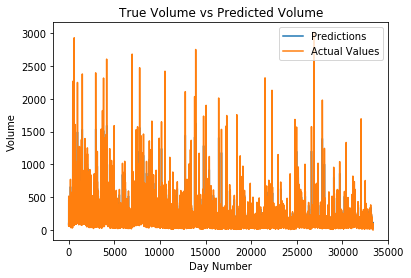

In [62]:
plt.plot(np.arange(0, len(pred), 1), pred, label = 'Predictions')
plt.plot(np.arange(0, len(y), 1), y, label = 'Actual Values')
plt.legend()
plt.xlabel('Day Number')
plt.ylabel('Volume')
plt.title('True Volume vs Predicted Volume')
RMSE = sqrt(mean_squared_error(y, pred))
print('                Test RMSE: %.3f' % RMSE)